Link to Kaggle dataset: https://www.kaggle.com/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/data

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.layers import Dense, BatchNormalization, Input, GlobalMaxPooling2D, Conv2D, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from keras.losses import BinaryCrossentropy


In [2]:
# Unzip file for processing
with zipfile.ZipFile("full-fundus.zip","r") as zip_ref:
    zip_ref.extractall("full-fundus")


In [3]:
# Read in metadata, and filter for a specific subset of images
image_data = pd.read_csv('metadata.csv')
image_data = image_data[image_data['names'].str.contains('FIVES', case=True) | image_data['names'].str.contains('HAGIS', case=True)
                       | image_data['names'].str.contains('LES-AV', case=True) | image_data['names'].str.contains('G1020', case=True)
                       | image_data['names'].str.contains('OIA', case=True) | image_data['names'].str.contains('ORIGA', case=True)
                       | image_data['names'].str.contains('EyePACS', case=True)]


image_data = image_data[['types', 'fundus', 'names']]

In [4]:
# There are some invalid data types for relevant columns
print(image_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9865 entries, 0 to 12448
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   9865 non-null   int64 
 1   fundus  9865 non-null   object
 2   names   9865 non-null   object
dtypes: int64(1), object(2)
memory usage: 308.3+ KB
None


In [5]:
# Change datatypes to the desired values
image_data['types'] = image_data['types'].astype('string')
image_data['fundus'] = image_data['fundus'].astype('string')
image_data['names'] = image_data['names'].astype('string')
image_data['image_names'] = image_data['names'] + '.png'

In [6]:
print(image_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9865 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   types        9865 non-null   string
 1   fundus       9865 non-null   string
 2   names        9865 non-null   string
 3   image_names  9865 non-null   string
dtypes: string(4)
memory usage: 385.4 KB
None


In [7]:
# Randomize data 
image_data_random = image_data.sample(frac=1, random_state=1)

# Split into healthy and glaucoma positive sets
healthy = image_data_random[image_data_random['types'] == "0"]
glaucoma = image_data_random[image_data_random['types'] == "1"]
inconclusive = image_data_random[image_data_random['types'] == "-1"]

print(f"Number of healthy samples: {len(healthy)}")
print(f"Number of unhealthy samples: {len(glaucoma)}")
print(f"Number of inconclusive samples: {len(inconclusive)}")

Number of healthy samples: 5618
Number of unhealthy samples: 4195
Number of inconclusive samples: 52


In [8]:
# Partition data into test and train sets
healthy_train_size = 5056
glaucoma_train_size = 3775
inconclusive_train_size = 46

healthy_test_subset = healthy.head(len(healthy) - healthy_train_size)
glaucoma_test_subset = glaucoma.head(len(glaucoma) - glaucoma_train_size)
inconclusive_test_subset = inconclusive.head(len(inconclusive) - inconclusive_train_size)
test_subset = pd.concat([healthy_test_subset, glaucoma_test_subset, inconclusive_test_subset])

healthy_train_subset = healthy.tail(healthy_train_size)
glaucoma_train_subset = glaucoma.tail(glaucoma_train_size)
inconclusive_train_subset = inconclusive.tail(inconclusive_train_size)
train_subset = pd.concat([healthy_train_subset, glaucoma_train_subset, inconclusive_train_subset])

print(f"Test size: {len(test_subset)}")
print(f"Train size: {len(train_subset)}")

Test size: 988
Train size: 8877


In [9]:
# Create data streams for the convolutional neural network model
train_data_generator = ImageDataGenerator(preprocessing_function= preprocess_input)

flow_train_data = train_data_generator.flow_from_dataframe(dataframe=train_subset, 
                                            batch_size= 8, 
                                            shuffle=True, 
                                            x_col="image_names", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(206, 206), 
                                            directory='full-fundus/full-fundus/', 
                                            color_mode='rgb')

test_data_generator = ImageDataGenerator(preprocessing_function= preprocess_input)

flow_test_data = train_data_generator.flow_from_dataframe(dataframe=test_subset, 
                                            batch_size= 8, 
                                            shuffle=False, 
                                            x_col="image_names", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(206, 206), 
                                            directory='full-fundus/full-fundus/', 
                                            color_mode='rgb')
# Classifications for target labels
print(flow_train_data.class_indices)

Found 8877 validated image filenames belonging to 3 classes.
Found 988 validated image filenames belonging to 3 classes.
{'-1': 0, '0': 1, '1': 2}


In [10]:
# Creates a convolutional neural network model for classifying fundus images
# Model is built on top of the MobileNetV3Large architecture if specified, using the predefined "imagenet" weights,
# and also using the softmax activation function
# Given image_size to cater the model to the size of the images
def conv_model(image_size, use_mobile_net):   
    m_input = keras.Input(shape=(image_size, image_size, 3))
    transfer = keras.applications.MobileNetV3Large(
        weights='imagenet', include_top= False, input_tensor= m_input, alpha=1.0
    )
    # Prevent the predefined MobileNetV3Large layers from being tuned
    for layer in transfer.layers:
        layer.trainable = False
    
    model = keras.Sequential()
    if use_mobile_net:
        model.add(transfer) 

    model.add(Conv2D(64, (3, 3), activation= "relu", name="conv_1", padding="same"))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation= "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation= 'softmax')) 

    return model

# Plots the feature outputs of a convolution layer
def plot_feature_outputs(feature_output):
    for ftr in feature_output:
        fig = plt.figure(figsize=(12, 12))
        for i in range(1, 64):
            fig = plt.subplot(rows, columns, i)
            fig.set_xticks([])
            fig.set_yticks([])
            plt.imshow(ftr[:, :, i], cmap= "inferno")
        plt.show()

# Model built on top of MobileNetV3Large architecture
model = conv_model(206, True)

# Using the Adam optimizer with binary cross entropy, compile the model using the given metrics
model.compile(optimizer= "adam", 
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy','Precision','Recall','AUC'])

trained_model = model.fit(flow_train_data, 
                    epochs=10,
                    batch_size=64,
                    validation_data= flow_test_data)

# Model NOT built on top of MobileNetV3Large architecture - used to visualize convolution layers
model_2 = conv_model(206, False)

# Using the Adam optimizer with binary cross entropy, compile the model using the given metrics
model_2.compile(optimizer= "adam", 
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy','Precision','Recall','AUC'])

trained_model_2 = model_2.fit(flow_train_data, 
                    epochs=10,
                    batch_size=64,
                    validation_data= flow_test_data)

/Users/ThomasMcBride/anaconda3/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/10


/Users/ThomasMcBride/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 75s 66ms/step - AUC: 0.8754 - Precision: 0.7247 - Recall: 0.7090 - accuracy: 0.7209 - loss: 0.4621 - val_AUC: 0.9413 - val_Precision: 0.8259 - val_Recall: 0.8259 - val_accuracy: 0.8259 - val_loss: 0.2959
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 73s 66ms/step - AUC: 0.9437 - Precision: 0.8298 - Recall: 0.8189 - accuracy: 0.8245 - loss: 0.2782 - val_AUC: 0.9528 - val_Precision: 0.8376 - val_Recall: 0.8350 - val_accuracy: 0.8370 - val_loss: 0.2613
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - AUC: 0.9593 - Precision: 0.8624 - Recall: 0.8554 - accuracy: 0.8600 - loss: 0.2350 - val_AUC: 0.9594 - val_Precision: 0.8548 - val_Recall: 0.8522 - val_accuracy: 0.8532 - val_loss: 0.2521
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 95s 86ms/step - AUC: 0.9661 - Precision: 0.8757 - Recall: 0.8687 - accuracy: 0.8723 - loss: 0.2102 - val_AUC: 0.9455 - val_Precision: 0.8421 - val_Recall: 0.8421 - val_accuracy: 0.8421 - val_loss: 0.2785
Epoch 5/10
1110/1110 ━━━━━━

In [11]:
print(model.summary())
print(model_2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 7, 7, 64)       │       553,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,669,003 (17.81 MB)

 Trainable params: 557,507 (2.13 MB)

 Non-trainable params: 2,996,480 (11.43 MB)

 Optimizer params: 1,115,016 (4.25 MB)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 206, 206, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 206, 206, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,955 (74.05 KB)

 Trainable params: 6,275 (24.51 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 12,552 (49.04 KB)

None


In [12]:
columns = 8
rows = 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


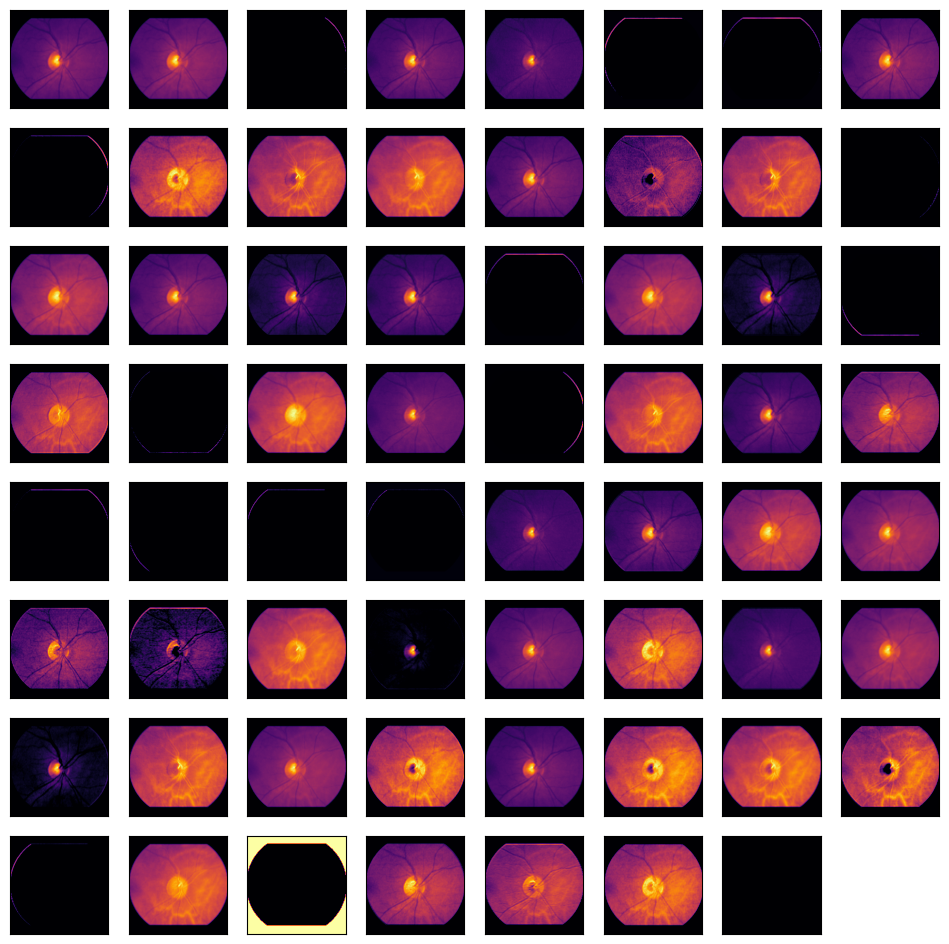

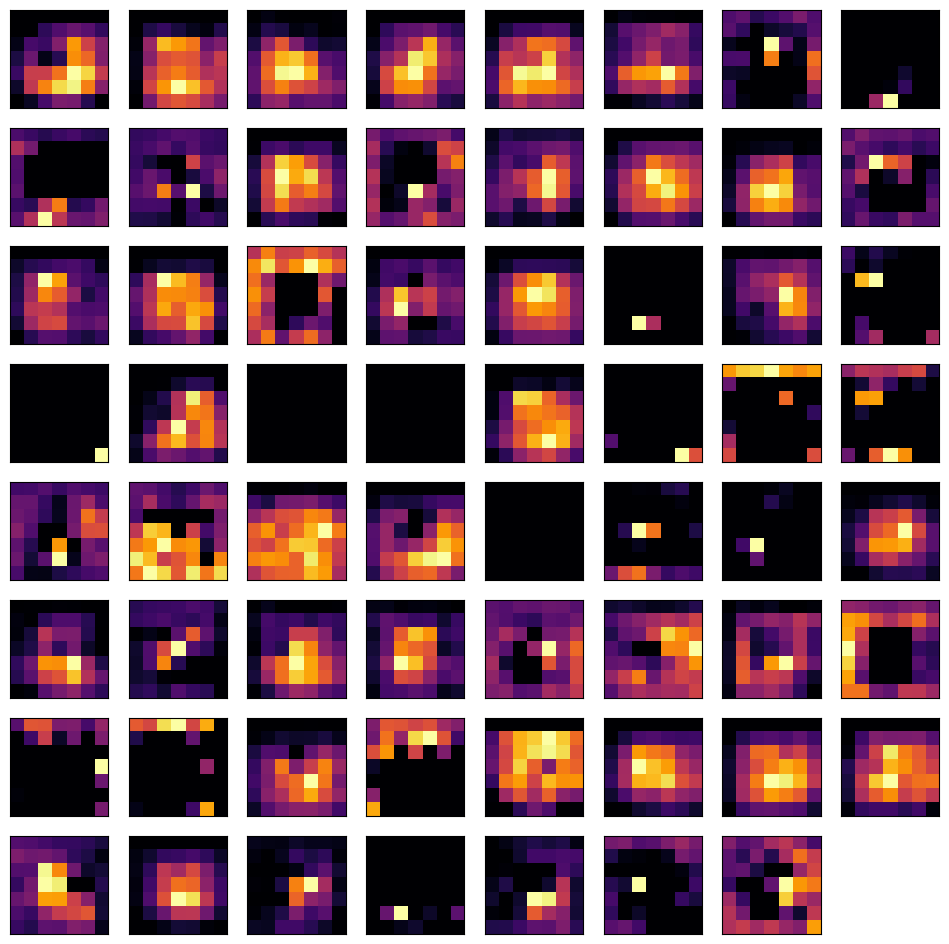

In [13]:
conv_layer_index = [0]
conv_layer_index_2 = [1]
outputs = [model_2.layers[i].output for i in conv_layer_index]
outputs_2 = [model.layers[i].output for i in conv_layer_index_2]
conv_model = Model(inputs=model_2.inputs, outputs=outputs)
conv_model_2 = Model(inputs=model.inputs, outputs=outputs_2)
img = image.load_img('full-fundus/full-fundus/PAPILA-1.png', target_size=(206, 206))


img_array_representation = np.expand_dims(img, axis=0)
img_array_representation = preprocess_input(img_array_representation)

feature_output = conv_model.predict(img_array_representation)
feature_output_2 = conv_model_2.predict(img_array_representation)

plot_feature_outputs(feature_output)
plot_feature_outputs(feature_output_2)

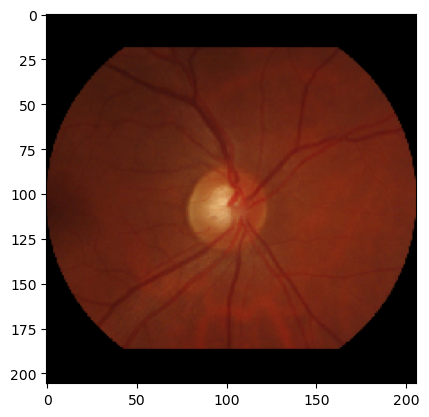

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Actual label: Glaucoma Suspected
Model 1 Prediction: Healthy, with 59.15396809577942% confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model 2 Prediction: Healthy, with 87.21475601196289% confidence


In [14]:
# Demonstration:
img = image.load_img('full-fundus/full-fundus/PAPILA-1.png', target_size=(206, 206))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation)

prediction = model.predict(img_array_representation)

print("Actual label: Glaucoma Suspected")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Model 1 Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Model 1 Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Model 1 Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")
    
prediction_2 = model_2.predict(img_array_representation)
# Interpret the prediction
if prediction_2[0][0] > prediction_2[0][1] and prediction_2[0][0] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction_2[0][1] > prediction_2[0][0] and prediction_2[0][1] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Healthy, with {prediction_2[0][1] * 100}% confidence")
else: 
    print(f"Model 2 Prediction: Glaucoma, with {prediction_2[0][2] * 100}% confidence")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


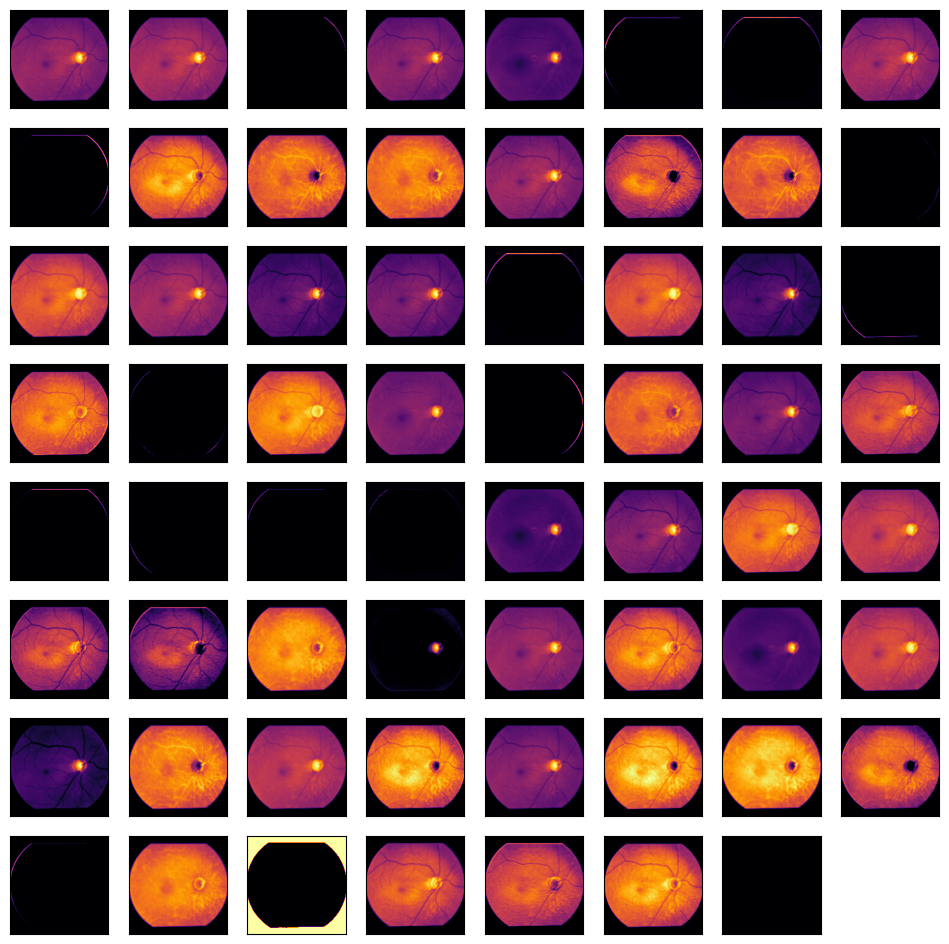

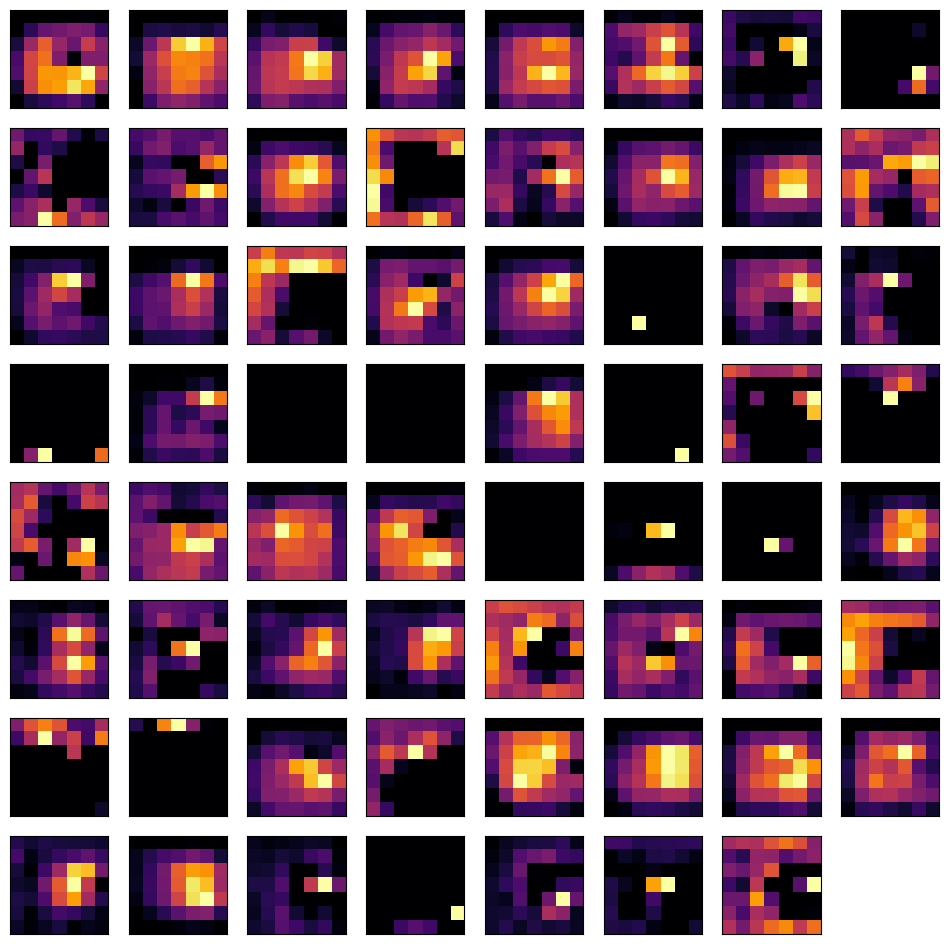

In [15]:
img = image.load_img('full-fundus/full-fundus/BEH-3.png', target_size=(206, 206))


img_array_representation = np.expand_dims(img, axis=0)
img_array_representation = preprocess_input(img_array_representation)

feature_output = conv_model.predict(img_array_representation)
feature_output_2 = conv_model_2.predict(img_array_representation)

plot_feature_outputs(feature_output)
plot_feature_outputs(feature_output_2)


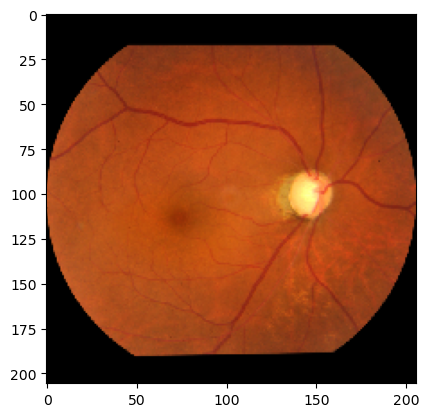

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Actual label: Glaucoma
Model 1 Prediction: Glaucoma, with 100.0% confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model 2 Prediction: Healthy, with 89.73138928413391% confidence


In [16]:
img = image.load_img('full-fundus/full-fundus/BEH-3.png', target_size=(206, 206))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation)  
prediction = model.predict(img_array_representation)
print("Actual label: Glaucoma")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Model 1 Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Model 1 Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Model 1 Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")
    
prediction_2 = model_2.predict(img_array_representation)
# Interpret the prediction
if prediction_2[0][0] > prediction_2[0][1] and prediction_2[0][0] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Glaucoma Suspected, with {prediction_2[0][0] * 100}% confidence")
elif prediction_2[0][1] > prediction_2[0][0] and prediction_2[0][1] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Healthy, with {prediction_2[0][1] * 100}% confidence")
else: 
    print(f"Model 2 Prediction: Glaucoma, with {prediction_2[0][2] * 100}% confidence")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


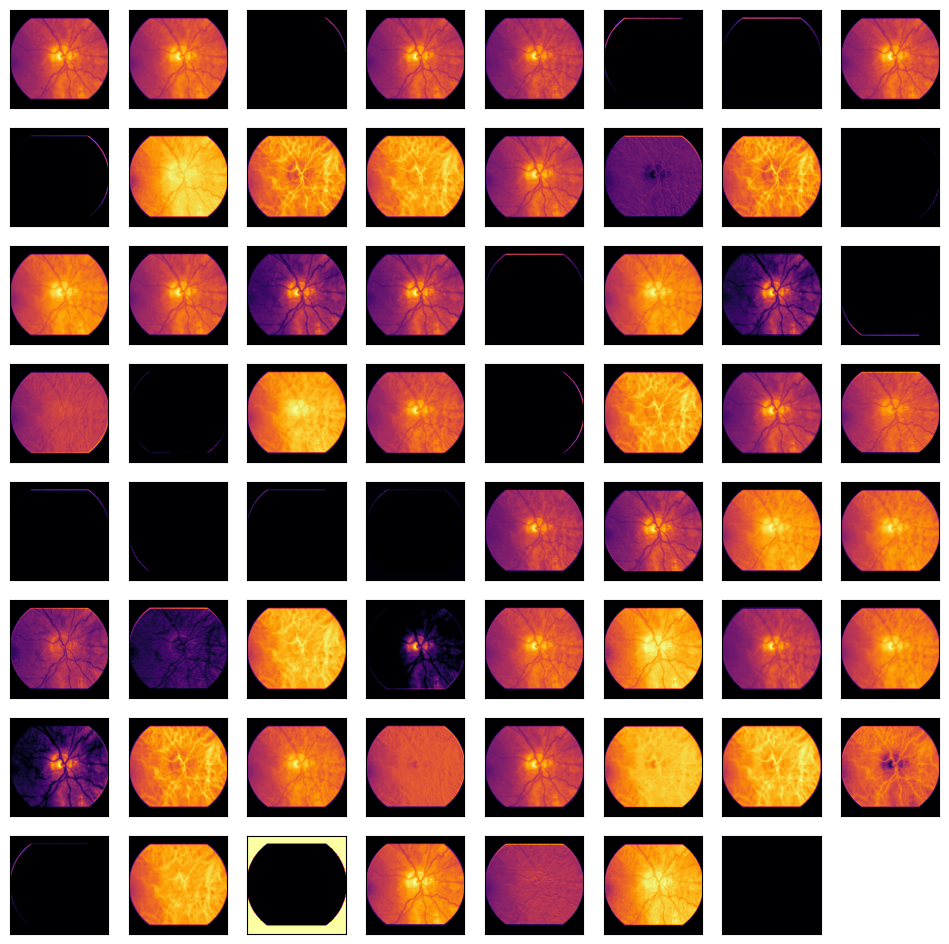

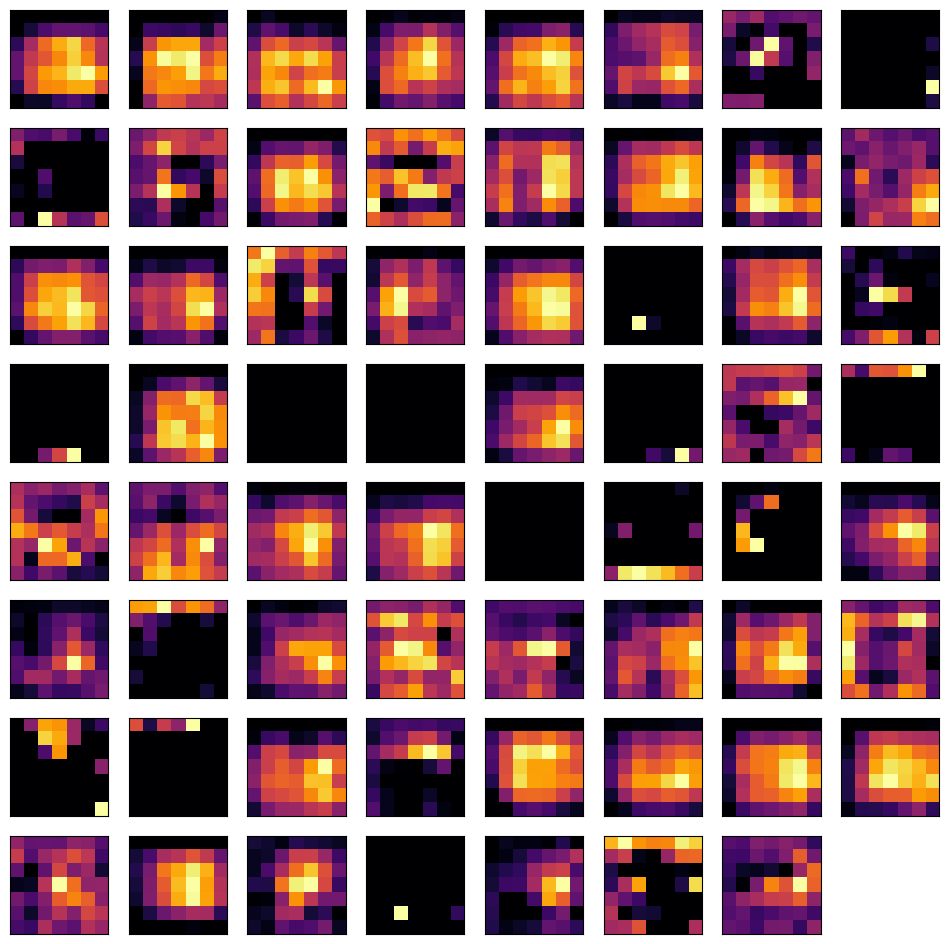

In [17]:
img = image.load_img('full-fundus/full-fundus/PAPILA-21.png', target_size=(206, 206))


img_array_representation = np.expand_dims(img, axis=0)
img_array_representation = preprocess_input(img_array_representation)

feature_output = conv_model.predict(img_array_representation)
feature_output_2 = conv_model_2.predict(img_array_representation)

plot_feature_outputs(feature_output)
plot_feature_outputs(feature_output_2)


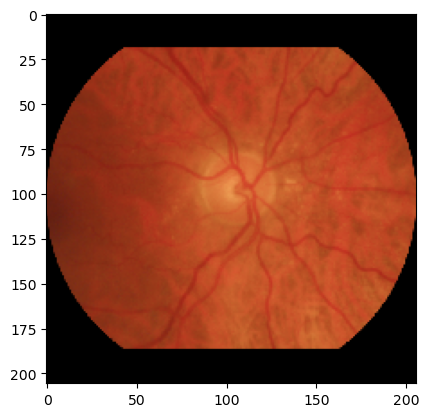

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual label: Healthy
Model 1 Prediction: Healthy, with 99.90443587303162% confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model 2 Prediction: Healthy, with 95.13256549835205% confidence


In [18]:
img = image.load_img('full-fundus/full-fundus/PAPILA-21.png', target_size=(206, 206))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation) 

prediction = model.predict(img_array_representation)
print("Actual label: Healthy")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Model 1 Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Model 1 Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Model 1 Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")
    
    
prediction_2 = model_2.predict(img_array_representation)
# Interpret the prediction
if prediction_2[0][0] > prediction_2[0][1] and prediction_2[0][0] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Glaucoma Suspected, with {prediction_2[0][0] * 100}% confidence")
elif prediction_2[0][1] > prediction_2[0][0] and prediction_2[0][1] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Healthy, with {prediction_2[0][1] * 100}% confidence")
else: 
    print(f"Model 2 Prediction: Glaucoma, with {prediction_2[0][2] * 100}% confidence")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


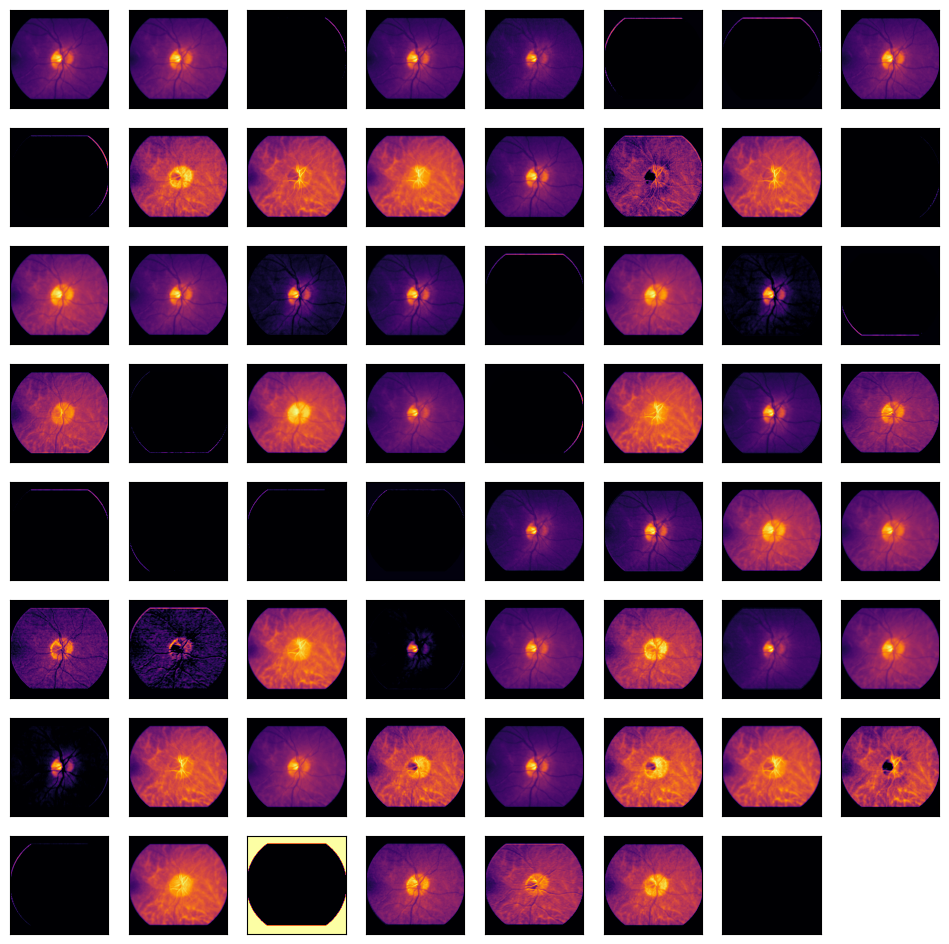

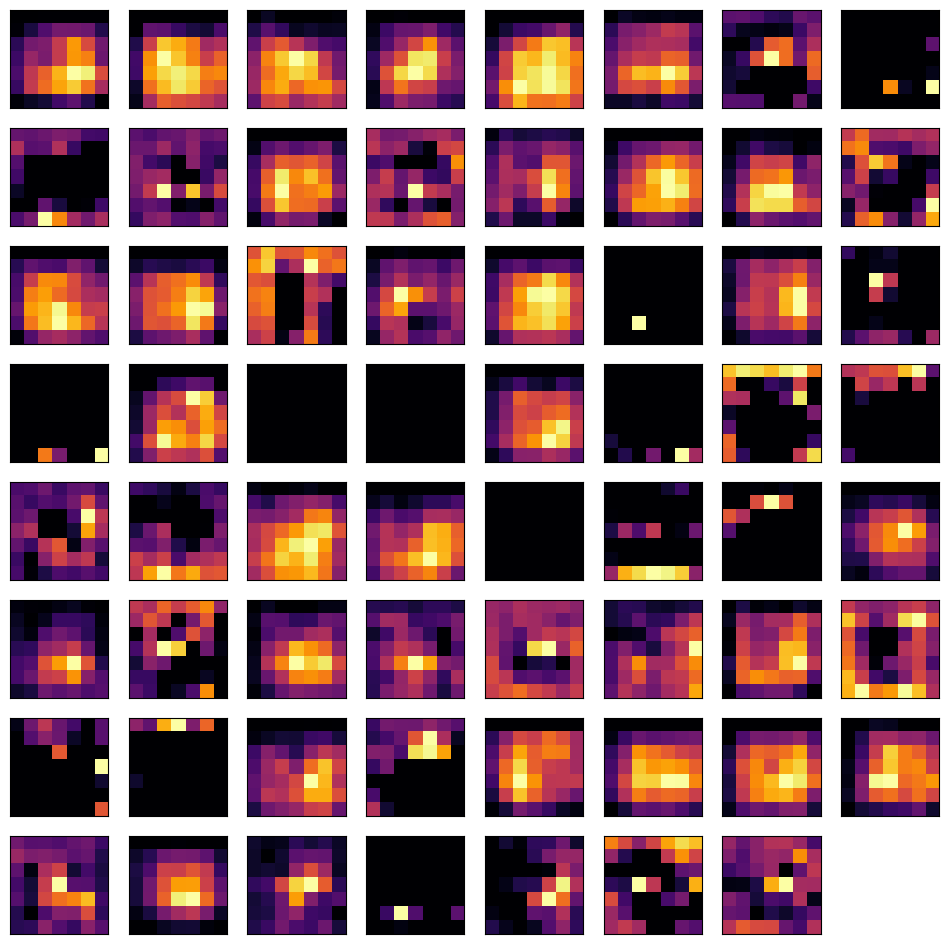

In [19]:
img = image.load_img('full-fundus/full-fundus/PAPILA-22.png', target_size=(206, 206))


img_array_representation = np.expand_dims(img, axis=0)
img_array_representation = preprocess_input(img_array_representation)

feature_output = conv_model.predict(img_array_representation)
feature_output_2 = conv_model_2.predict(img_array_representation)

plot_feature_outputs(feature_output)
plot_feature_outputs(feature_output_2)


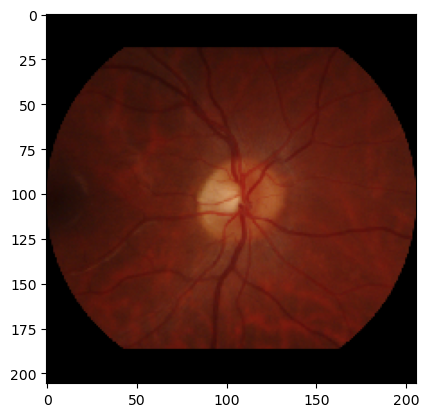

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual label: Healthy
Model 1 Prediction: Healthy, with 97.05151319503784% confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Model 2 Prediction: Healthy, with 86.00367307662964% confidence


In [20]:
img = image.load_img('full-fundus/full-fundus/PAPILA-22.png', target_size=(206, 206))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation) 

prediction = model.predict(img_array_representation)
print("Actual label: Healthy")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Model 1 Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Model 1 Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Model 1 Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")
    
    
prediction_2 = model_2.predict(img_array_representation)
# Interpret the prediction
if prediction_2[0][0] > prediction_2[0][1] and prediction_2[0][0] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Glaucoma Suspected, with {prediction_2[0][0] * 100}% confidence")
elif prediction_2[0][1] > prediction_2[0][0] and prediction_2[0][1] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Healthy, with {prediction_2[0][1] * 100}% confidence")
else: 
    print(f"Model 2 Prediction: Glaucoma, with {prediction_2[0][2] * 100}% confidence")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


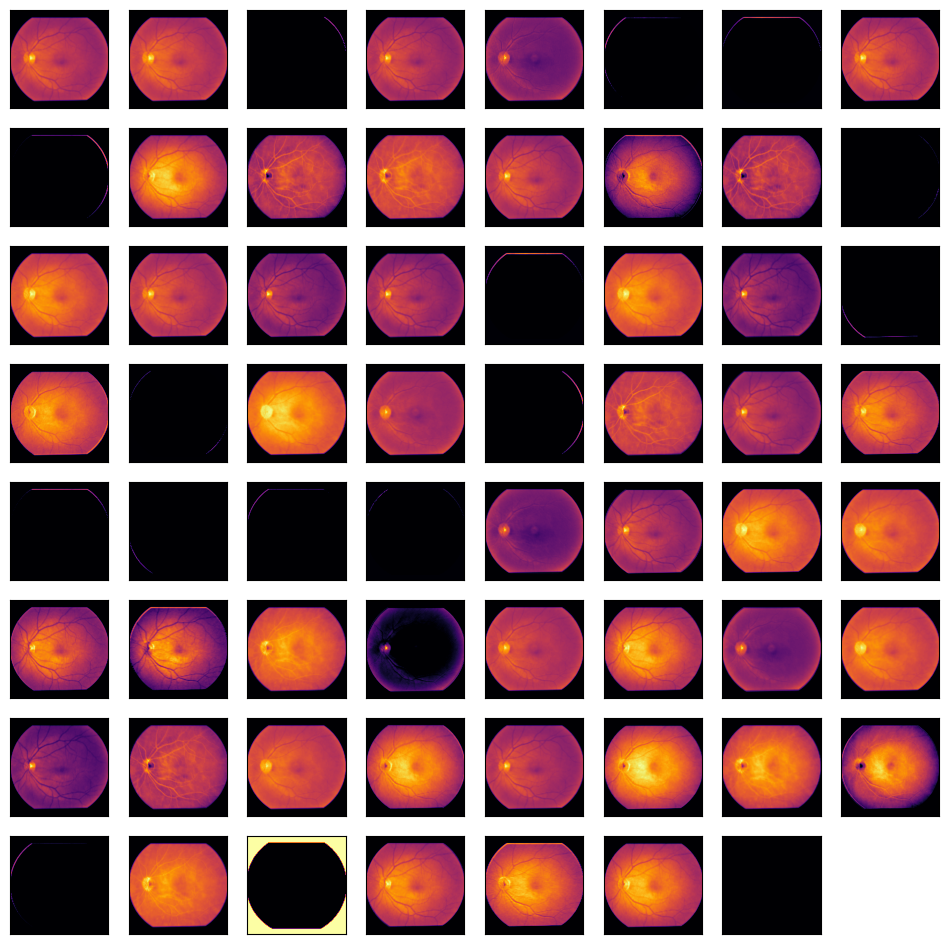

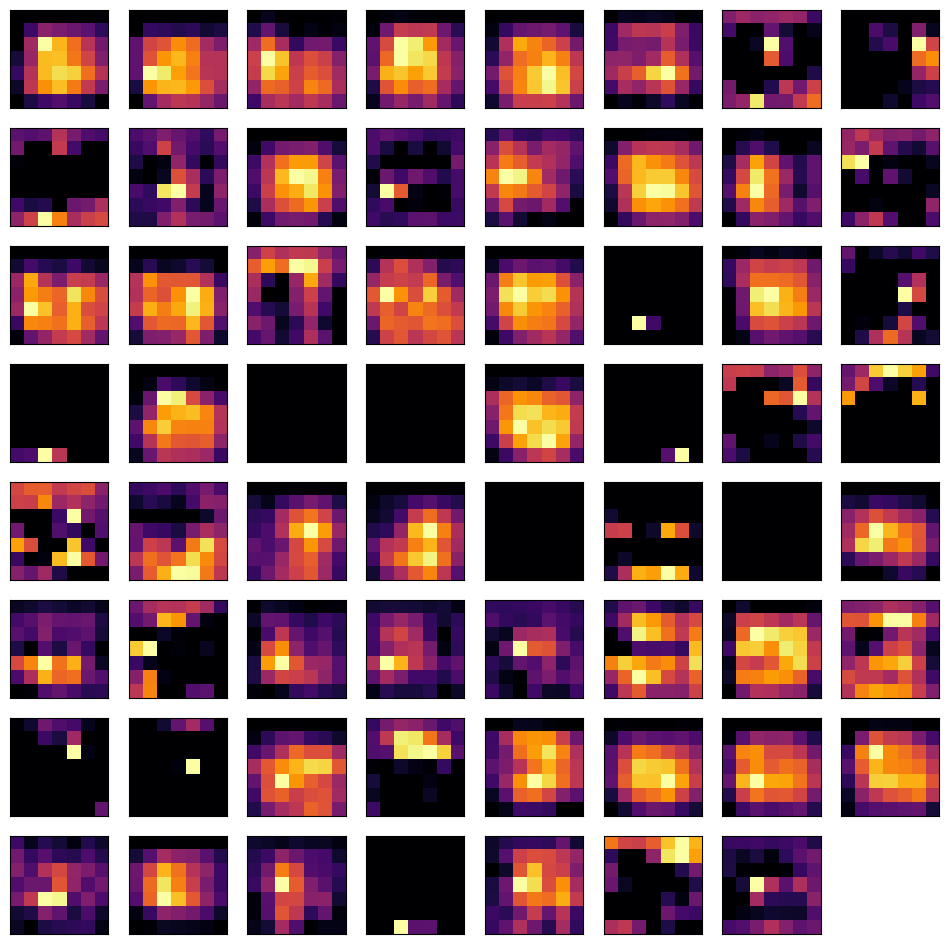

In [21]:
img = image.load_img('full-fundus/full-fundus/BEH-233.png', target_size=(206, 206))


img_array_representation = np.expand_dims(img, axis=0)
img_array_representation = preprocess_input(img_array_representation)

feature_output = conv_model.predict(img_array_representation)
feature_output_2 = conv_model_2.predict(img_array_representation)

plot_feature_outputs(feature_output)
plot_feature_outputs(feature_output_2)


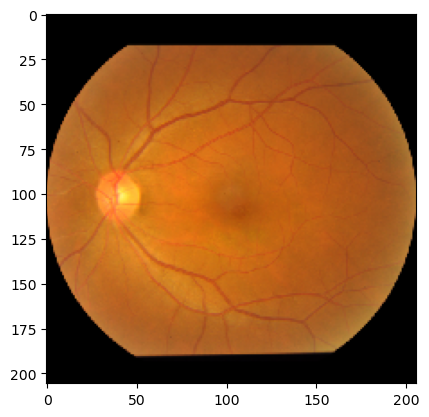

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual label: Healthy
Model 1 Prediction: Healthy, with 100.0% confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model 2 Prediction: Healthy, with 89.25752639770508% confidence


In [22]:
img = image.load_img('full-fundus/full-fundus/BEH-233.png', target_size=(206, 206))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation) 
prediction = model.predict(img_array_representation)
print("Actual label: Healthy")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Model 1 Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Model 1 Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Model 1 Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")
    
    
prediction_2 = model_2.predict(img_array_representation)
# Interpret the prediction
if prediction_2[0][0] > prediction_2[0][1] and prediction_2[0][0] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Glaucoma Suspected, with {prediction_2[0][0] * 100}% confidence")
elif prediction_2[0][1] > prediction_2[0][0] and prediction_2[0][1] > prediction_2[0][2]:
    print(f"Model 2 Prediction: Healthy, with {prediction_2[0][1] * 100}% confidence")
else: 
    print(f"Model 2 Prediction: Glaucoma, with {prediction_2[0][2] * 100}% confidence")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


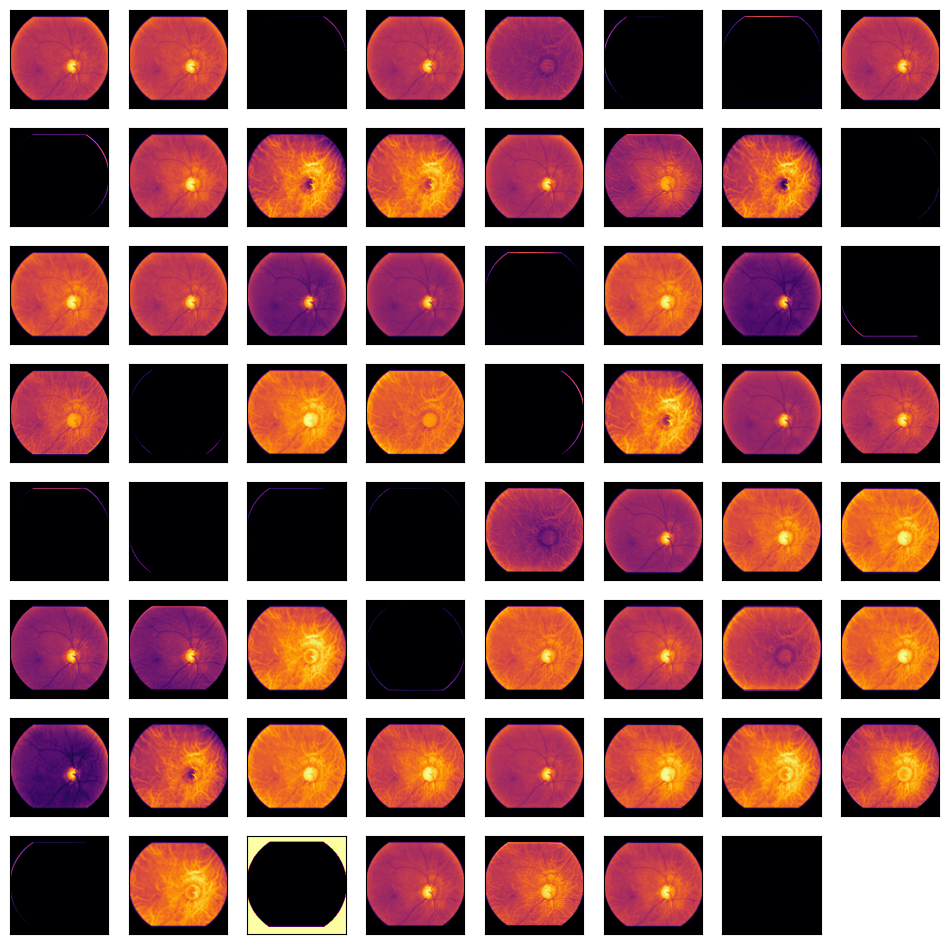

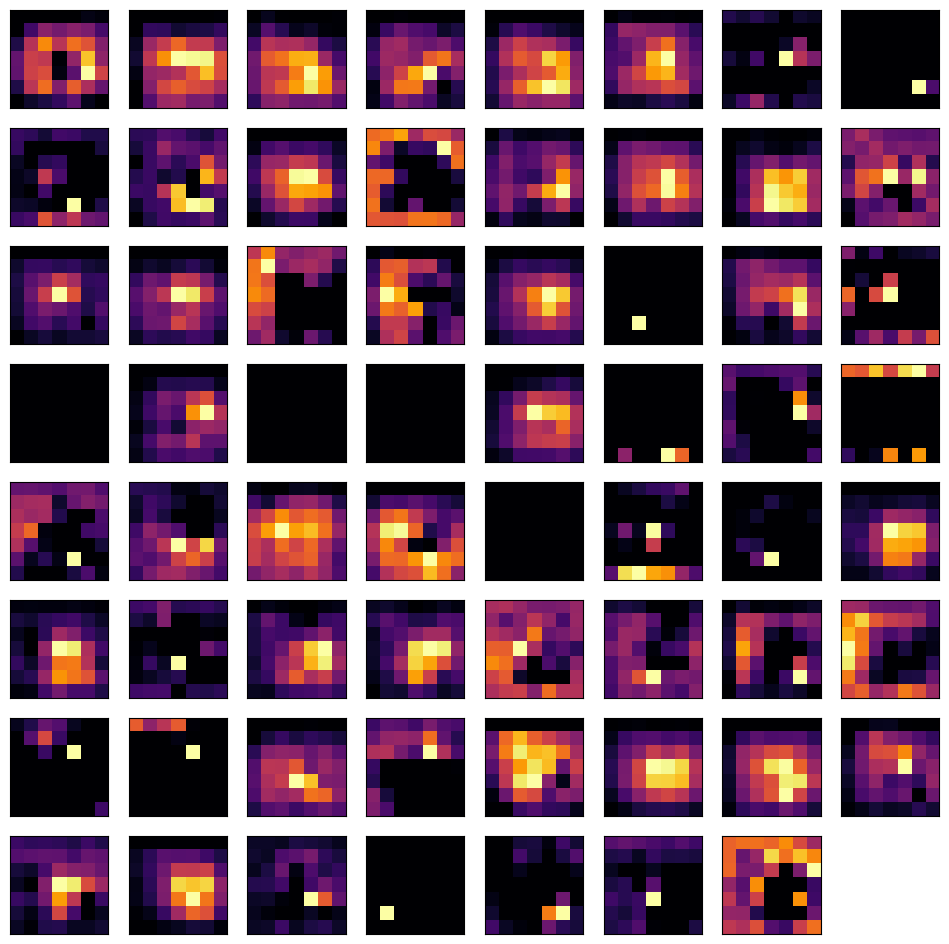

In [23]:
img = image.load_img('full-fundus/full-fundus/JSIEC-1000-46.png', target_size=(206, 206))


img_array_representation = np.expand_dims(img, axis=0)
img_array_representation = preprocess_input(img_array_representation)

feature_output = conv_model.predict(img_array_representation)
feature_output_2 = conv_model_2.predict(img_array_representation)

plot_feature_outputs(feature_output)
plot_feature_outputs(feature_output_2)


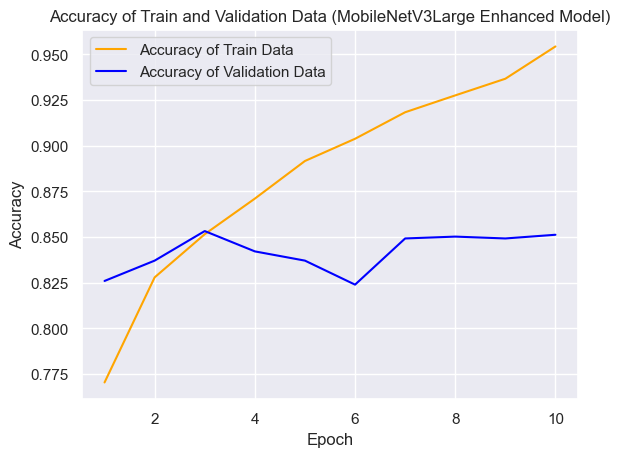

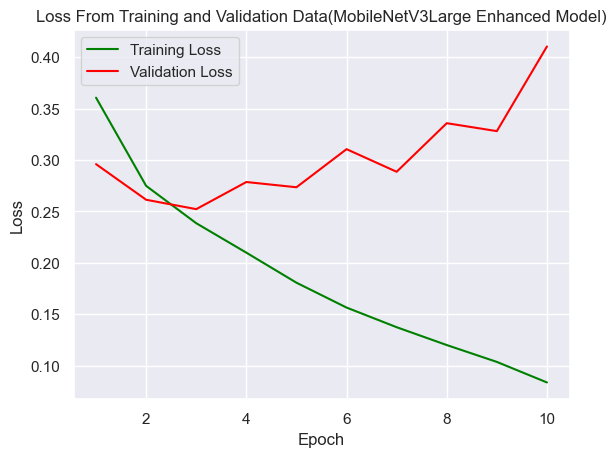

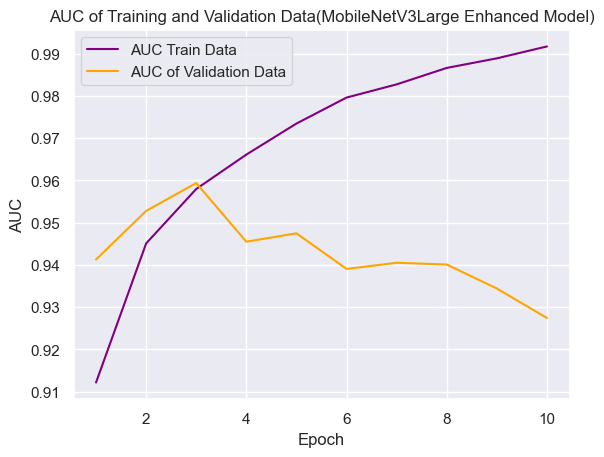

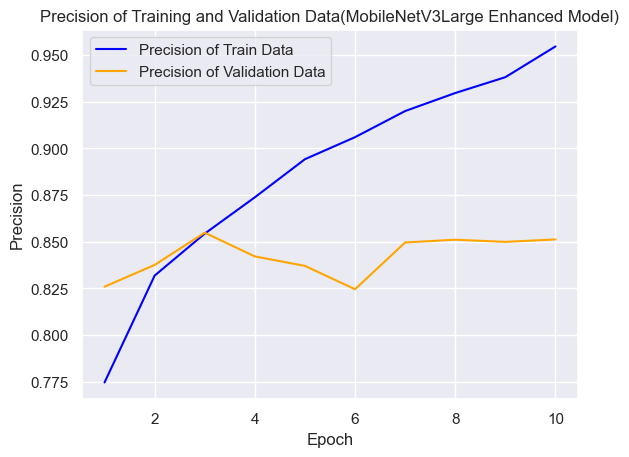

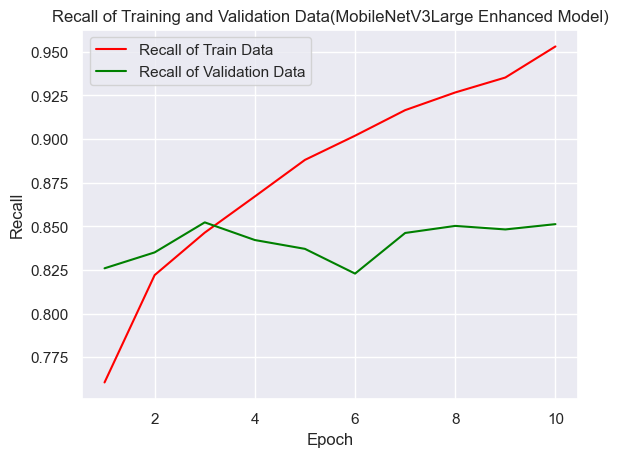

<Figure size 640x480 with 0 Axes>

In [24]:
sns.set()

accuracy = trained_model.history['accuracy']
validation_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
auc = trained_model.history['AUC']
val_AUC = trained_model.history['val_AUC']
precision = trained_model.history['Precision']
val_precision = trained_model.history['val_Precision']
recall = trained_model.history['Recall']
val_Recall = trained_model.history['val_Recall']


plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(range(1, len(loss) + 1), accuracy, color='orange', label='Accuracy of Train Data')
plt.plot(range(1, len(loss) + 1), validation_accuracy, color='blue', label='Accuracy of Validation Data')
plt.title('Accuracy of Train and Validation Data (MobileNetV3Large Enhanced Model)')

plt.legend()

plt.figure()
# Loss plot
plt.plot(range(1, len(loss) + 1), loss, color='green', label='Training Loss')
plt.plot(range(1, len(loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('Loss From Training and Validation Data(MobileNetV3Large Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure()

# AUC plot
plt.plot(range(1, len(loss) + 1), auc, color='purple', label='AUC Train Data')
plt.plot(range(1, len(loss) + 1), val_AUC, color='orange', label='AUC of Validation Data')
plt.title('AUC of Training and Validation Data(MobileNetV3Large Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.figure()

# Precision plot
plt.plot(range(1, len(loss) + 1), precision, color='blue', label='Precision of Train Data')
plt.plot(range(1, len(loss) + 1), val_precision, color='orange', label='Precision of Validation Data')
plt.title('Precision of Training and Validation Data(MobileNetV3Large Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.figure()

# Recall plot
plt.plot(range(1, len(loss) + 1), recall, color='red', label='Recall of Train Data')
plt.plot(range(1, len(loss) + 1), val_Recall, color='green', label='Recall of Validation Data')
plt.title('Recall of Training and Validation Data(MobileNetV3Large Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.figure()
plt.show()

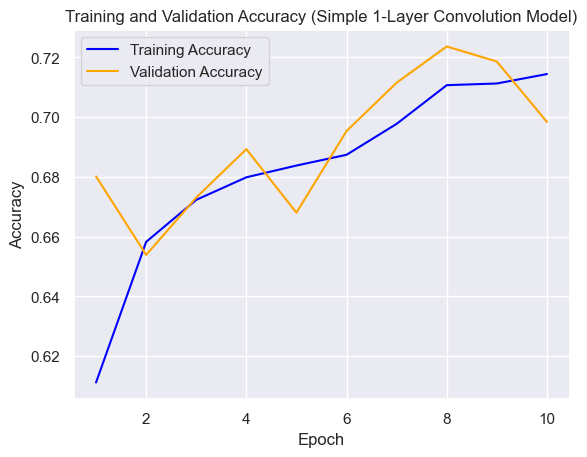

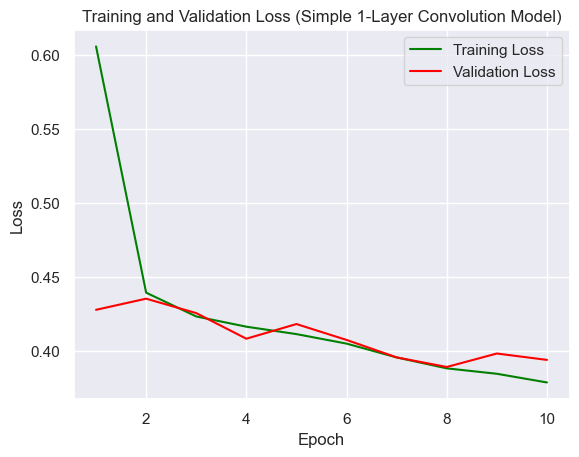

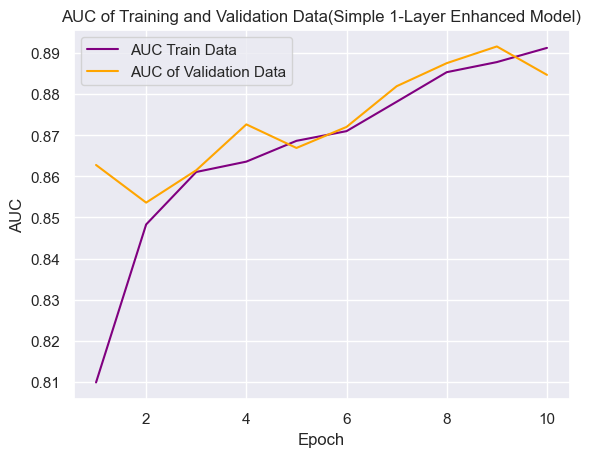

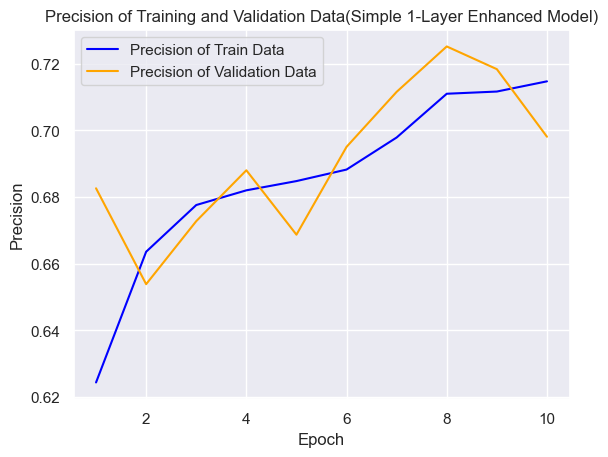

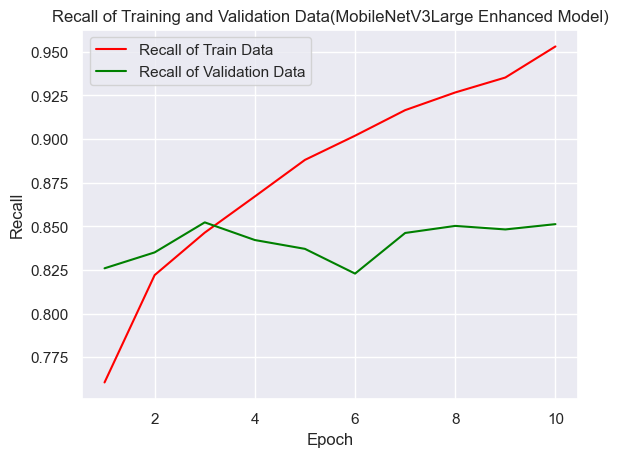

<Figure size 640x480 with 0 Axes>

In [25]:
sns.set()

accuracy = trained_model_2.history['accuracy']
val_accuracy = trained_model_2.history['val_accuracy']
loss = trained_model_2.history['loss']
val_loss = trained_model_2.history['val_loss']
auc = trained_model_2.history['AUC']
val_AUC = trained_model_2.history['val_AUC']
precision = trained_model_2.history['Precision']
val_precision = trained_model_2.history['val_Precision']
recall = trained_model.history['Recall']
val_Recall = trained_model.history['val_Recall']

# Accuracy plot
plt.plot(range(1, len(loss) + 1), accuracy, color='blue', label='Training Accuracy')
plt.plot(range(1, len(loss) + 1), val_accuracy, color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Simple 1-Layer Convolution Model)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
# Loss plot
plt.plot(range(1, len(loss) + 1), loss, color='green', label='Training Loss')
plt.plot(range(1, len(loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss (Simple 1-Layer Convolution Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure()

# AUC plot
plt.plot(range(1, len(loss) + 1), auc, color='purple', label='AUC Train Data')
plt.plot(range(1, len(loss) + 1), val_AUC, color='orange', label='AUC of Validation Data')
plt.title('AUC of Training and Validation Data(Simple 1-Layer Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.figure()

# Precision plot
plt.plot(range(1, len(loss) + 1), precision, color='blue', label='Precision of Train Data')
plt.plot(range(1, len(loss) + 1), val_precision, color='orange', label='Precision of Validation Data')
plt.title('Precision of Training and Validation Data(Simple 1-Layer Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.figure()

# Recall plot
plt.plot(range(1, len(loss) + 1), recall, color='red', label='Recall of Train Data')
plt.plot(range(1, len(loss) + 1), val_Recall, color='green', label='Recall of Validation Data')
plt.title('Recall of Training and Validation Data(MobileNetV3Large Enhanced Model)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.figure()

plt.show()